In [16]:
import pandas as pd
import numpy as np
import seaborn as sns

In [17]:
master = pd.read_csv("/Users/premsundar/Downloads/DA/cyclist/master.csv")

In [18]:
master.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0,D90034EFC7235A41,electric_bike,2025-12-22 17:20:27.872,2025-12-22 17:27:29.937,Broadway & Berwyn Ave,CHI00414,Broadway & Sunnyside Ave,CHI02089,41.978361,-87.659789,41.963419,-87.656069,member
1,1,B005230EE77A29D0,classic_bike,2025-12-20 17:15:31.749,2025-12-20 17:20:07.746,Sheridan Rd & Montrose Ave,CHI00290,Broadway & Sheridan Rd,CHI00476,41.961670,-87.654640,41.952833,-87.649993,member
2,2,FD33124F2231E215,classic_bike,2025-12-06 13:38:18.275,2025-12-06 13:52:54.682,Southport Ave & Wrightwood Ave,CHI00339,Larrabee St & Menomonee St,CHI00262,41.928773,-87.663913,41.914680,-87.643320,casual
3,3,7363165DB4BD6D14,electric_bike,2025-12-16 20:58:28.703,2025-12-16 21:04:35.476,Sheridan Rd & Montrose Ave,CHI00290,Clark St & Newport St,CHI00674,41.961670,-87.654640,41.944540,-87.654678,member
4,4,F09F745E43DF9556,electric_bike,2025-12-09 14:53:43.347,2025-12-09 14:58:30.944,Larrabee St & Kingsbury St 1,CHI00245,Rush St & Superior St,CHI00368,41.897764,-87.642884,41.895765,-87.625908,member


In [19]:
master.dtypes

Unnamed: 0              int64
ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [20]:
master["started_at"] = pd.to_datetime(master["started_at"])
master["ended_at"] = pd.to_datetime(master["ended_at"])

In [21]:
master.dtypes

Unnamed: 0                     int64
ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

In [22]:
master.shape

(5552994, 14)

In [23]:
master.isna().sum()

Unnamed: 0                  0
ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1184673
start_station_id      1184673
end_station_name      1243305
end_station_id        1243305
start_lat                   0
start_lng                   0
end_lat                  5535
end_lng                  5535
member_casual               0
dtype: int64

<Axes: xlabel='rideable_type', ylabel='Count'>

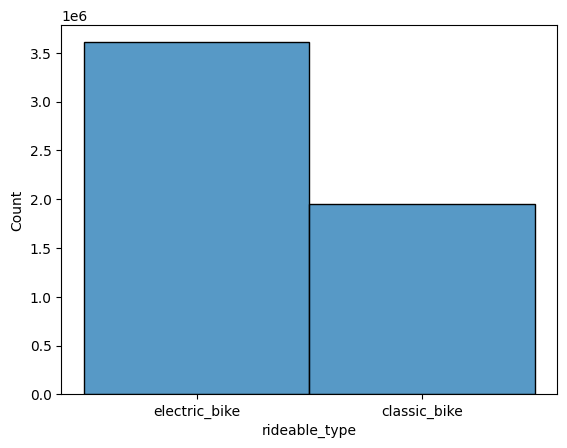

In [25]:
sns.histplot(master["rideable_type"])

In [32]:
# new features

master['ride_length'] =  master['ended_at'] - master['started_at'] 

master['ride_length_mins'] = master['ride_length'].dt.total_seconds() / 60

master['ride_length_mins'].head()

0     7.034417
1     4.599950
2    14.606783
3     6.112883
4     4.793283
Name: ride_length_mins, dtype: float64

In [30]:
# day of the week

master['day_of_the_week'] = master['started_at'].dt.day_name()


master['day_of_the_week'].head()

0      Monday
1    Saturday
2    Saturday
3     Tuesday
4     Tuesday
Name: day_of_the_week, dtype: object

In [34]:
master['month'] = master['started_at'].dt.month

master['month'].head()

0    12
1    12
2    12
3    12
4    12
Name: month, dtype: int32

In [36]:
master['hour_of_day'] = master['started_at'].dt.hour
master['hour_of_day'].head()

0    17
1    17
2    13
3    20
4    14
Name: hour_of_day, dtype: int32

In [37]:
def calculate_ride_distance(df):
    # Earth's radius in kilometers
    R = 6371.0 

    # Convert degrees to radians for all coordinate columns
    lat1, lon1 = np.radians(df['start_lat']), np.radians(df['start_lng'])
    lat2, lon2 = np.radians(df['end_lat']), np.radians(df['end_lng'])

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate final distance
    return R * c

# Apply to your dataset
master['ride_distance'] = calculate_ride_distance(master)

In [38]:
master['ride_distance'].head()

0    1.689698
1    1.055090
2    2.314854
3    1.904772
4    1.422542
Name: ride_distance, dtype: float64

In [ ]:
""" Analysis and Strategy

   1. Missing Station Information (`start_station_name`, `end_station_name`, etc.)

       * Insight: The large number of missing station names (over 1 million) is likely not random error. It's a business
         insight: a significant number of trips do not start or end at a physical docking station. This is a key behavior,
         especially if it's more common among casual users.
       * Strategy: Do not drop these rows. Dropping them would discard a huge portion of your data and hide this important
         user behavior. Instead, treat this as a feature. We can flag these as "dockless" trips.
       * Action: We will fill the missing station names and IDs with the placeholder "off-network".

   2. Missing End Coordinates (`end_lat`, `end_lng`)

       * Insight: The 5,535 missing end coordinates represent a much smaller data quality issue, possibly from rides that
         were not properly terminated or had a GPS/device failure.
       * Strategy: The impact of dropping these rows is minimal on the overall dataset. Calculating ride distance for these
         trips is impossible, and imputing a location would be inaccurate. For analyses that don't require end_lat/end_lng
         (like ride duration by user type), they could be kept, but for simplicity and consistency, it is better to remove
         them.
       * Action: We will drop these rows. """ 

In [ ]:
# Strategy for station data: Fill missing values
station_cols = ['start_station_name' , 'start_station_id' , 'end_station_name' , 'end_station_id']
master[station_cols] = master[station_cols].fillna('off-network')

In [41]:
# Strategy for end coordinates: Drop rows with missing values
master.dropna(subset=['end_lat', 'end_lng'], inplace=True)

In [42]:
master.drop(columns=['Unnamed: 0'], inplace=True)

In [43]:
print("missing values after cleaing")
master.isnull().sum()

missing values after cleaing


ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
ride_length           0
day_of_the_week       0
ride_length_mins      0
month                 0
hour_of_day           0
ride_distance         0
dtype: int64

In [44]:
master.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_the_week,ride_length_mins,month,hour_of_day,ride_distance
0,D90034EFC7235A41,electric_bike,2025-12-22 17:20:27.872,2025-12-22 17:27:29.937,Broadway & Berwyn Ave,CHI00414,Broadway & Sunnyside Ave,CHI02089,41.978361,-87.659789,41.963419,-87.656069,member,0 days 00:07:02.065000,Monday,7.034417,12,17,1.689698
1,B005230EE77A29D0,classic_bike,2025-12-20 17:15:31.749,2025-12-20 17:20:07.746,Sheridan Rd & Montrose Ave,CHI00290,Broadway & Sheridan Rd,CHI00476,41.961670,-87.654640,41.952833,-87.649993,member,0 days 00:04:35.997000,Saturday,4.599950,12,17,1.055090
2,FD33124F2231E215,classic_bike,2025-12-06 13:38:18.275,2025-12-06 13:52:54.682,Southport Ave & Wrightwood Ave,CHI00339,Larrabee St & Menomonee St,CHI00262,41.928773,-87.663913,41.914680,-87.643320,casual,0 days 00:14:36.407000,Saturday,14.606783,12,13,2.314854
3,7363165DB4BD6D14,electric_bike,2025-12-16 20:58:28.703,2025-12-16 21:04:35.476,Sheridan Rd & Montrose Ave,CHI00290,Clark St & Newport St,CHI00674,41.961670,-87.654640,41.944540,-87.654678,member,0 days 00:06:06.773000,Tuesday,6.112883,12,20,1.904772
4,F09F745E43DF9556,electric_bike,2025-12-09 14:53:43.347,2025-12-09 14:58:30.944,Larrabee St & Kingsbury St 1,CHI00245,Rush St & Superior St,CHI00368,41.897764,-87.642884,41.895765,-87.625908,member,0 days 00:04:47.597000,Tuesday,4.793283,12,14,1.422542


In [ ]:
#phase 2: Descriptive Analysis

In [45]:
master.dtypes

ride_id                        object
rideable_type                  object
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name             object
start_station_id               object
end_station_name               object
end_station_id                 object
start_lat                     float64
start_lng                     float64
end_lat                       float64
end_lng                       float64
member_casual                  object
ride_length           timedelta64[ns]
day_of_the_week                object
ride_length_mins              float64
month                           int32
hour_of_day                     int32
ride_distance                 float64
dtype: object

In [47]:
master[['ride_length_mins' , 'ride_distance']].describe()

,ride_length_mins,ride_distance
count,5.547459e+06,5.547459e+06
mean,1.457352e+01,2.202809e+00
std,2.977862e+01,1.994849e+00
min,-5.479480e+01,0.000000e+00
25%,5.391483e+00,9.081145e-01
50%,9.416633e+00,1.615363e+00
75%,1.653006e+01,2.879226e+00
max,1.499968e+03,4.056503e+01


In [ ]:
# --- INTERPRETATION OF DESCRIPTIVE STATISTICS ---

# 1. DATA CLEANING ALERTS:
# - ride_length_mins MIN (-54.79): Negative values detected. This implies 'ended_at' < 'started_at'.
#   ACTION: Remove rows where ride_length_mins <= 0.
# - ride_distance MIN (0.00): 0km trips exist. Likely 'circular' trips (start/end at same station).
#   ACTION: Decide if these represent valid leisure rides or accidental check-outs.

# 2. RIDE DURATION (ride_length_mins):
# - MEAN (14.57) vs MEDIAN (9.42): The mean is ~55% higher than the median.
# - SKEWNESS: The data is heavily right-skewed; a few very long trips are pulling the average up.
# - OUTLIERS: The MAX (1,499.97) is ~25 hours. These may be stolen bikes or system errors.
# - TYPICAL USE: 75% of users finish their rides in under 16.53 minutes.

# 3. RIDE DISTANCE (ride_distance):
# - CENTRAL TENDENCY: Average trip is ~2.20km, but the typical (median) trip is only ~1.62km.
# - CONSISTENCY: 75% of all rides cover less than 2.88km.
# - SHORT TRIPS: 25% of rides are less than 1km (908 meters), suggesting high "last-mile" usage.

# 4. VOLUMETRICS:
# - COUNT: ~5.55 Million rides processed. This is a robust sample size for statistical significance.


<Axes: xlabel='ride_length_mins', ylabel='Count'>

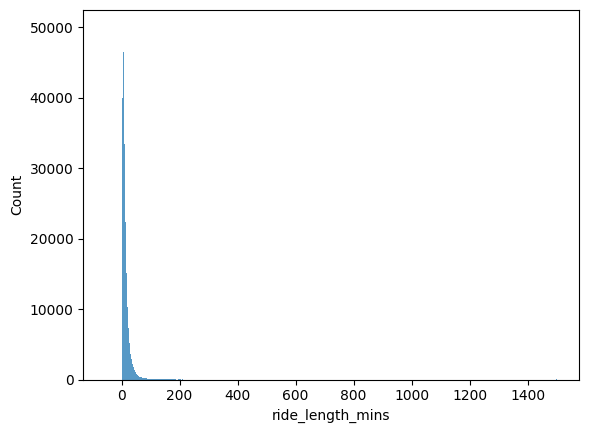

In [50]:
sns.histplot(master['ride_length_mins'])

In [ ]:
# zero distance
zero_distance_rides = master[master['ride_distance'] == 0]
zero_distance_rides['ride_distance'].count()

np.int64(337583)

In [65]:
false_starts = zero_distance_rides[zero_distance_rides['ride_length_mins'] <= 3]
round_trips = zero_distance_rides[zero_distance_rides['ride_length_mins'] > 3]
print("-" * 35 + "\n")
print("--- Applying Cleaning Rules ---")
initial_rows = len(master)
print(f"Initial rows: {initial_rows}")

# Rule 1: Remove rides with negative or zero duration
master_cleaned = master[master['ride_length_mins'] > 0].copy()
rows_after_duration_filter = len(master_cleaned)
print(f"Rows removed for negative/zero duration: {initial_rows - rows_after_duration_filter}")

# Rule 2: Remove 0-distance "False Starts" (duration <= 3 mins)
# We create a boolean mask to identify the rows to REMOVE

is_false_start = (master_cleaned['ride_distance'] == 0) & (master_cleaned['ride_length_mins'] <= 3)
rows_to_remove = is_false_start.sum()
master_cleaned = master_cleaned[~is_false_start] # Using ~ to keep rows that are NOT false starts

print(f"Rows removed for 'False Starts': {rows_to_remove}")
print(f"Final rows after all cleaning: {len(master_cleaned)}")
print("-" * 35)

-----------------------------------

--- Applying Cleaning Rules ---
Initial rows: 5547459
Rows removed for negative/zero duration: 29
Rows removed for 'False Starts': 164827
Final rows after all cleaning: 5382603
-----------------------------------


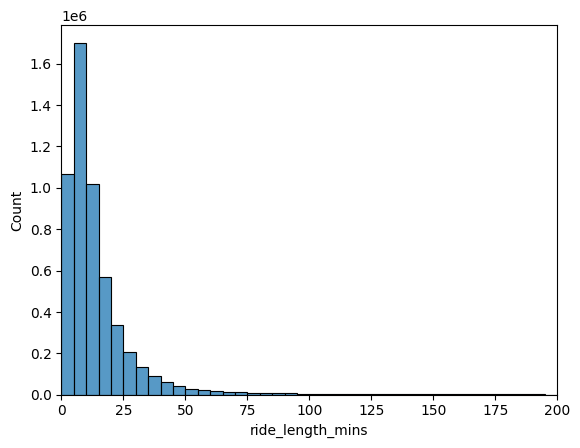

In [70]:
import matplotlib.pyplot as plt

# Using binrange to limit data grouping to 0-200 mins
sns.histplot(data=master_cleaned, x='ride_length_mins', binrange=(0, 200), bins=40)

# Optional: Force the x-axis display to exactly 0-200
plt.xlim(0, 200)
plt.show()
